In [1]:
import pandas as pd
import datetime
from datetime import timedelta
from math import radians, cos, sin, asin, sqrt
import numpy as np
import scipy.sparse as spa
import cvxpy as cp
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [2]:
full_data = pd.read_csv("yellow_tripdata_2010-01.csv")
full_data['pickup_datetime'] = pd.to_datetime(full_data['pickup_datetime'])
full_data['dropoff_datetime'] = pd.to_datetime(full_data['dropoff_datetime'])

year = 2010
month = 1
day = 21
date = datetime.date(year, month, day)
midnight = datetime.datetime(year, month, day, 0, 0)

day_data = full_data.loc[(full_data['pickup_datetime'].dt.date == date) & (full_data['dropoff_datetime'].dt.date == date)]
day_data = day_data[['pickup_datetime', 'dropoff_datetime', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']]
day_data = day_data.loc[(day_data['pickup_longitude'] != 0) & (day_data['pickup_latitude'] != 0)]

n = 200
data = day_data.sample(n).sort_values(by = 'pickup_datetime')
data.index = range(n)
data

C:\Users\holly\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,2010-01-21 00:09:03,2010-01-21 00:14:08,1.40,-74.003643,40.739420,-74.001449,40.733936,5.7,0.5,0.5,0.00,0.0,6.70
1,2010-01-21 00:14:00,2010-01-21 00:45:00,4.84,-74.005307,40.720490,-73.990647,40.667075,18.5,0.5,0.5,0.00,0.0,19.50
2,2010-01-21 00:30:00,2010-01-21 00:35:00,1.65,-73.965780,40.762830,-73.977630,40.746900,5.7,0.5,0.5,0.00,0.0,6.70
3,2010-01-21 00:46:46,2010-01-21 00:51:02,1.00,-73.955575,40.779288,-73.976233,40.788267,4.5,0.5,0.5,0.00,0.0,5.50
4,2010-01-21 00:57:49,2010-01-21 01:01:09,1.30,-74.042763,40.711476,-74.042763,40.711476,5.3,0.5,0.5,1.57,0.0,7.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2010-01-21 22:57:43,2010-01-21 23:07:32,1.60,-73.987853,40.728690,-73.972650,40.681220,7.3,0.5,0.5,0.00,0.0,8.30
196,2010-01-21 22:59:00,2010-01-21 23:02:00,1.03,-73.985428,40.727465,-73.979253,40.739712,4.5,0.5,0.5,0.00,0.0,5.50
197,2010-01-21 23:01:58,2010-01-21 23:31:17,4.70,-73.972380,40.793968,-74.003114,40.731534,18.1,0.5,0.5,0.00,0.0,19.10
198,2010-01-21 23:28:37,2010-01-21 23:38:39,1.20,-73.973807,40.748723,-73.989040,40.740587,6.5,1.0,0.0,0.00,0.0,7.50


In [3]:
def to_td(minutes):
    td = []
    for m in minutes:
        td.append(timedelta(minutes = m))
    return td

def to_minutes(td):
    return td.total_seconds() / 60

def T(i,j):
    if (i == j or i == n+taxis): return 0
    # From customer to sink
    if (j == n+taxis+1): return -9999999
        # dist_between = haversine(data.loc[i, 'pickup_longitude'], data.loc[i, 'pickup_latitude'], taxi_lon, taxi_lat)
        # time_between = timedelta(hours = dist_between / mph)
        # output = data.loc[i, 'dropoff_datetime'] - data.loc[i, 'pickup_datetime'] + time_between
    # From taxi to customer
    if (i >= n):
        dist_between = haversine(taxi_lon, taxi_lat, data.loc[j, 'pickup_longitude'], data.loc[j, 'pickup_latitude'])
        output = timedelta(hours = dist_between / mph)
    # From customer to customer
    else:
        dist_between = haversine(data.loc[i,'dropoff_longitude'], data.loc[i, 'dropoff_latitude'],
                                  data.loc[j, 'pickup_longitude'], data.loc[j, 'pickup_latitude'])
        time_between = timedelta(hours = dist_between / mph)
        output = data.loc[i, 'dropoff_datetime'] - data.loc[i, 'pickup_datetime'] + time_between
    return output.total_seconds() / 60

# def B(arcs):
    

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 3956
    return c * r

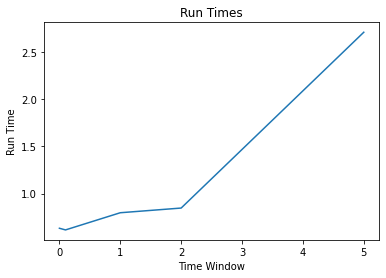

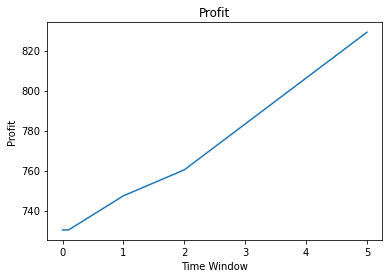

In [8]:
window_mins = [0, .1, 1, 2, 5]
time_windows = to_td(window_mins)
run_times = []
objectives = []

taxis = 2            # Number of taxis
taxi_lon = -73.9772  # Initial longitude of taxis
taxi_lat = 40.7527   # Initial latitude of taxis
mph = 20             # Taxi speed between passengers
driving_cost = .6    # in dollars per mile

possible = np.zeros((n+taxis+2, n+taxis+2))  # =1 if connection (i,j) is possible, =0 if impossible
profit_accept = np.zeros((n+taxis+2, n+taxis+2))   # Net profit from accepting passenger j (based on preceding passenger i)
                                         # Note: =0 if connection (i,j) is impossible
source = n + taxis
sink = n + taxis + 1
taxi_cost = 100  # Cost of deploying a taxi in dollars

for time_window in time_windows:
    
    for i in range(n):
        for j in range(n):
            if (i == j): continue

            dist_between = haversine(data.loc[i,'dropoff_longitude'], data.loc[i, 'dropoff_latitude'],
                                          data.loc[j, 'pickup_longitude'], data.loc[j, 'pickup_latitude'])
            time_between = timedelta(hours = dist_between / mph)
            if (data.loc[i, 'dropoff_datetime'] + time_between > data.loc[j, 'pickup_datetime'] + time_window): continue
            else: possible[i,j] = 1
            profit_accept[i,j] = data.loc[j, 'total_amount'] - driving_cost * (dist_between + data.loc[j, 'trip_distance'])
        
        possible[i, sink] = 1
        dist_between = haversine(data.loc[i, 'dropoff_longitude'], data.loc[i, 'dropoff_latitude'], taxi_lon, taxi_lat)
        profit_accept[i, sink] = -driving_cost * dist_between

    for k in range(n, n+taxis):
        for j in range(n):

            dist_between = haversine(taxi_lon, taxi_lat, data.loc[j, 'pickup_longitude'], data.loc[j, 'pickup_latitude'])
            time_between = timedelta(hours = dist_between / mph)
            if (midnight + time_between > data.loc[j, 'pickup_datetime'] + time_window): continue
            else: possible[k,j] = 1
            profit_accept[k,j] = data.loc[j, 'total_amount'] - driving_cost * (dist_between + data.loc[j, 'trip_distance'])
        
        possible[source, k] = 1
        profit_accept[source, k] = -taxi_cost
        
    t_min = []
    t_max = []
        
    for i in range(n):
        t_min.append(to_minutes(data.loc[i, 'pickup_datetime'] - midnight))
        t_max.append(to_minutes(data.loc[i, 'pickup_datetime'] - midnight + time_window))
    for k in range(n, n+taxis+2):
        t_min.append(0)
        t_max.append(0)
    
    s_list = []
    p_list = []
    
    arcs = {}
    num_arcs = np.count_nonzero(possible)
    A_in = spa.dok_matrix((n+taxis+2, num_arcs))
    A_out = spa.dok_matrix((n+taxis+2, num_arcs))
    cost = np.zeros(num_arcs)
    
    # For time window constraints
    B = spa.dok_matrix((num_arcs, num_arcs))
    d = np.zeros(num_arcs)
    
    a = 0
    for i in range(n+taxis+2):

        successors = []
        predecessors = []

        for j in range(n+taxis+2):
            if (possible[i,j] == 1):
                successors.append(j)
                if (j > i):
                    arcs[(i,j)] = a
                    A_in[i, a] = 1
                    A_out[j, a] = 1
                    B[a, a] = t_max[i] - t_min[j] + T(i,j)
                    d[a] = t_max[i] - t_min[j]
                    cost[a] = profit_accept[i,j]
                    a += 1
                    
            if (possible[j,i] == 1):
                predecessors.append(j)
                if (j > i):
                    arcs[(j,i)] = a
                    A_in[j, a] = 1
                    A_out[i, a] = 1
                    B[a, a] = t_max[j] - t_min[i] + T(j,i)
                    d[a] = t_max[j] - t_min[i]
                    cost[a] = profit_accept[j,i]
                    a += 1
                
        s_list.append(successors)
        p_list.append(predecessors)
    
    A = A_in - A_out
    C = np.transpose(A[:n,])
    e = np.zeros(n+taxis+2)
    e[source] = taxis
    e[sink] = -taxis
    
    # Maximum Flow Problem CVXPY
    x = cp.Variable(num_arcs, boolean = True)
    t = cp.Variable(n)
    
    ## Network Flow Constraints
    constraints = [A @ x <= e]
    inflow = A_in @ x
    constraints += [inflow[:n+taxis] <= 1]
    ## Time Window Constraints
    constraints += [t_min[:n] <= t, t <= t_max[:n]]
    constraints += [B @ x + C @ t <= d]
    
    profit = np.transpose(cost) @ x
    objective = cp.Maximize(profit)
    problem = cp.Problem(objective, constraints)
    
    sims = 100
    run_time = 0
    for i in range(sims):
        problem.solve()
        run_time += problem.solver_stats.solve_time
    run_times.append(run_time/sims)
#     problem.solve()
#     run_times.append(problem.solver_stats.solve_time)
    objectives.append(objective.value)
    
#     x_val = spa.dok_matrix((n+taxis+2, n+taxis+2))
#     for i in range(n+taxis+2):
#         for j in s_list[i]:
#             x_val[i,j] = x[arcs.get((i,j))].value
#     print("Window:", time_window)
#     print(x_val.tocoo())
#     print(objective.value)

plt.figure(1)
plt.plot(window_mins, run_times);
plt.title("Run Times");
plt.xlabel("Time Window");
plt.ylabel("Run Time");
plt.figure(2)
plt.plot(window_mins, objectives);
plt.title("Profit");
plt.xlabel("Time Window");
plt.ylabel("Profit");

In [5]:
x_val = spa.dok_matrix((n+taxis+2, n+taxis+2))
for i in range(n+taxis+2):
    for j in s_list[i]:
        x_val[i,j] = x[arcs.get((i,j))].value
print("Time Window:", time_window)
print(x_val.tocoo())
print(objective.value)

Time Window: 0:05:00
  (0, 1)	1.0
  (1, 4)	1.0
  (2, 3)	1.0
  (3, 5)	1.0
  (4, 7)	1.0
  (5, 8)	1.0
  (7, 10)	1.0
  (8, 13)	1.0
  (10, 11)	1.0
  (11, 12)	1.0
  (12, 17)	1.0
  (13, 15)	1.0
  (15, 16)	1.0
  (16, 18)	1.0
  (17, 19)	1.0
  (18, 20)	1.0
  (19, 24)	1.0
  (20, 21)	1.0
  (21, 23)	1.0
  (23, 25)	1.0
  (24, 26)	1.0
  (25, 28)	1.0
  (26, 30)	1.0
  (28, 32)	1.0
  (30, 36)	1.0
  :	:
  (148, 151)	1.0
  (150, 154)	1.0
  (151, 155)	1.0
  (154, 156)	1.0
  (155, 163)	1.0
  (156, 162)	1.0
  (162, 177)	1.0
  (163, 171)	1.0
  (171, 173)	1.0
  (173, 175)	1.0
  (175, 178)	1.0
  (177, 187)	1.0
  (178, 179)	1.0
  (179, 181)	1.0
  (181, 185)	1.0
  (185, 189)	1.0
  (187, 198)	1.0
  (189, 197)	1.0
  (197, 199)	1.0
  (198, 203)	1.0
  (199, 203)	1.0
  (200, 2)	1.0
  (201, 0)	1.0
  (202, 200)	1.0
  (202, 201)	1.0
829.1856443658959


In [6]:
arcs = np.asarray(np.nonzero(x_val))
# locs = np.unique(arcs[arcs < 200])
# lons = data.iloc[locs, 3]
# lats = data.iloc[locs, 4]

loc_origin = arcs[0][:-taxis-2]
loc_destin = arcs[1][:-taxis-2]

lon_origin = data.iloc[loc_origin, 3].to_numpy()
lat_origin = data.iloc[loc_origin, 4].to_numpy()
lon_destin = data.iloc[loc_destin, 3].to_numpy()
lat_destin = data.iloc[loc_destin, 4].to_numpy()

IndexError: positional indexers are out-of-bounds

In [ ]:
# from shapely.geometry import Point, LineString
from matplotlib.patches import FancyArrowPatch

nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
# nyc = nyc.to_crs(epsg=3857)
nyc = nyc.to_crs(epsg=4326)
ax = nyc.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

ax.set_xlim(-74.05, -73.85)
ax.set_ylim(40.68, 40.82)

# nodes = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lons, lats))
# nodes.plot(color='green')

fig = plt.figure()

# One Taxi's Journey
taxi_num = n + 1
node = arcs[1][np.where(arcs[0] == taxi_num)] # First node (rider) for given taxi
while True:
    where = np.array(np.where(loc_origin == node))
    if (where.size == 0): break
    i = where[0][0]
    dx = lon_destin[i] - lon_origin[i]
    dy = lat_destin[i] - lat_origin[i]
    ax.arrow(lon_origin[i], lat_origin[i], dx, dy, color = 'pink', width=.0004)
    node = loc_destin[i]

plt.show()

In [ ]:
# # CVXPY
# # Create variables
# p = {}
# x = {}
# t = {}
# t_min = {}
# t_max = {}
# for i in range(n):
#     p[i] = cp.Variable(boolean = True)
#     t[i] = cp.Variable()
#     t_min[i] = to_minutes(data.loc[i, 'pickup_datetime'] - midnight)
#     t_max[i] = to_minutes(data.loc[i, 'pickup_datetime'] - midnight + time_window)
# for i in range(n+taxis):
#     for j in s_list[i]:
#         x[i,j] = cp.Variable(boolean = True)

# constraints = []
# constraints += [cp.sum([x[i,j] for i in p_list[j]]) == p[j] for j in range(n)]
# constraints += [cp.sum([x[i,j] for j in s_list[i]]) <= p[i] for i in range(n)]
# constraints += [cp.sum([x[k,j] for j in s_list[k]]) <= 1 for k in range(n, n+taxis)]
# constraints += [t_min[i] <= t[i] for i in range(n)]
# constraints += [t[i] <= t_max[i] for i in range(n)]
# constraints += [t[j] - t[i] >= (t_min[j] - t_max[i]) + (T(i,j) - (t_min[j] - t_max[i])) * x[i,j]
#                 for i in range(n) for j in s_list[i]]
# constraints += [t[j] >= t_min[j] + (T(k,j) - t_min[j]) * x[k,j]
#                 for k in range(n, n+taxis) for j in s_list[k]]

# profit = cp.sum([profit_accept[i,j] * x[i,j] for i in range(n+taxis) for j in s_list[i]])
# objective = cp.Maximize(profit)
# problem = cp.Problem(objective, constraints)

# run_time = 0
# obj = 0
# for sims in range(100):
#     problem.solve()
#     run_time += problem.solver_stats.solve_time
#     obj += objective.value
# run_times.append(run_time/sims)
# objectives.append(obj/sims)

# x_val = spa.dok_matrix((n+taxis, n+taxis))
# for i in range(n+taxis):
#     for j in s_list[i]:
#         x_val[i,j] = x[i,j].value
# print(x_val.tocoo())
# print(objective.value)